## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import pystan

In [2]:
# import the data-set
data = pd.read_csv(
    "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv", 
    skiprows=44, names=["Date", "CO2_concentration"])
print(data.shape)
data.head()

(3139, 2)


,Date,CO2_concentration
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [3]:
#convert the "Date" column into datetime64 dtype
data["Date"] = pd.to_datetime(data["Date"])

In [4]:
data["Days_Passed"] = ((pd.to_datetime(data.Date) - pd.to_datetime(data.Date[0])).dt.days)
data["Years"] = ((pd.to_datetime(data.Date) - pd.to_datetime(data.Date[0])).dt.days)/365.25
data.tail()

,Date,CO2_concentration,Days_Passed,Years
3134,2019-08-31,409.32,22435,61.423682
3135,2019-09-07,408.80,22442,61.442847
3136,2019-09-14,408.61,22449,61.462012
3137,2019-09-21,408.50,22456,61.481177
3138,2019-09-28,408.28,22463,61.500342


In [5]:
# check datatypes
result = data.dtypes
result

Date                 datetime64[ns]
CO2_concentration           float64
Days_Passed                   int64
Years                       float64
dtype: object

In [6]:
#check for missing values
data.isnull().sum()

Date                 0
CO2_concentration    0
Days_Passed          0
Years                0
dtype: int64

/Users/denniskageni/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


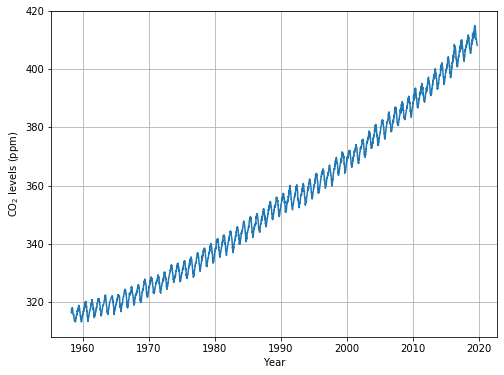

In [7]:
# plotting the data (1958 - 2019)
figure_1 = plt.figure(figsize=(8,6))
plt.plot(data.Date, data.CO2_concentration)
plt.grid()
plt.xlabel("Year")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()

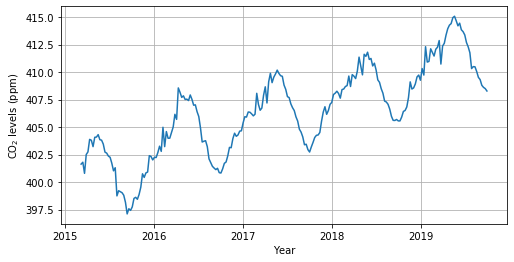

In [63]:
# zooming into the data to observe the trend, season variation and noise closely; 
# plotting from 2014-2019
figure_2 = plt.figure(figsize=(8,4))
plt.plot(data.loc[2900:, ["Date"]], data.loc[2900:, ["CO2_concentration"]])
plt.grid()
plt.xlabel("Year")
plt.ylabel(r'CO$_2$ levels (ppm)')
#plt.yticks(np.linspace(392, 412, 6))
plt.show()

In [9]:
#stan data
stan_data = {
                'N': len(data), 
                'co2': data.CO2_concentration.values,
                'time': data.Years.values
            }

normalized_stan_data = {
                'N': len(data), 
                'co2': data.CO2_concentration.values,
                'time': data.Years.values/np.max(data.Years.values)
            }

In [16]:
linear_trend = """
data {
    int<lower=0> N;             // number of data collected
    real<lower=0> time[N];      // days passed since 1958-03-29
    real<lower=0> co2[N];       // measured CO2 concentration in ppm
}

parameters {
    real<lower=0> c0;                
    real<lower=0> c1;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0 ~ normal(310, 30);       // based on data min value & stdev
    c1 ~ gamma(0.5, 0.5);       // rough guess on scale of the slope of the
                                // trend but with wide stdev
    noise ~ inv_gamma(10, 2);   // relatively uninformative prior on the same
                                // scale as the data
    
    // Trend Model
    for (i in 1:N) {
        co2[i] ~ normal(c0 + c1*time[i], noise); 
    }
}

"""

exp_trend = """
data {
    int<lower=0> N;             // number of data
    real<lower=0> time[N];      // days since start of measurement
    real<lower=0> co2[N];       // measured CO2 in ppm
}

parameters {
    real<lower=0> c0;                
    real<lower=0> c1;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0 ~ normal(310, 30);       
    c1 ~ gamma(1, 1);         // expecting c1 to be relatively small 
    noise ~ inv_gamma(5, 2);      
    
    // Trend Model
    for (i in 1:N) {
        co2[i] ~ normal(c0 * exp(c1 * time[i]), noise); 
    }
}

"""

quadratic_trend = """
data {
    int<lower=0> N;             // number of data
    real<lower=0> time[N];      // days since start of measurement
    real<lower=0> co2[N];       // measured ppm
}

parameters {
    real<lower=0> c0;                
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0 ~ normal(310, 30);
    c1 ~ normal(0.5, 0.5);
    c2 ~ normal(0.1, 0.1);
    
    noise ~ normal(10, 2);
    
    for (i in 1:N) {
        co2[i] ~ normal(c0 + c1*time[i] + c2 *(time[i]^2), noise); 
    }
}

"""

In [17]:
linear_model = pystan.StanModel(model_code=linear_trend)
exp_model = pystan.StanModel(model_code=exp_trend)
quadratic_model = pystan.StanModel(model_code=quadratic_trend)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_789e2d7c51c643644fddbfcaf6735ea9 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_428bba425b3d6dec0d2282be720c0406 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a9c7f6d45d34ed33e0b178a1321ab504 NOW.


In [18]:
linear_results = linear_model.sampling(data=stan_data, iter=2000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 10, 'adapt_delta' : 0.999},
                              refresh = 50)
print(linear_results)

Inference for Stan model: anon_model_789e2d7c51c643644fddbfcaf6735ea9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    306.07  4.7e-3   0.17 305.76 305.95 306.06 306.18 306.41   1221    1.0
c1      1.57  1.4e-4 4.6e-3   1.56   1.57   1.57   1.58   1.58   1111    1.0
noise   4.26  1.6e-3   0.06   4.16   4.23   4.26    4.3   4.37   1224    1.0
lp__   -6135    0.04   1.32  -6138  -6135  -6134  -6134  -6133   1040    1.0

Samples were drawn using NUTS at Thu Dec 19 15:57:45 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [19]:
exp_results = exp_model.sampling(data=normalized_stan_data, iter=2000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 10, 'adapt_delta' : 0.999},
                              refresh = 50)
print(exp_results)

Inference for Stan model: anon_model_428bba425b3d6dec0d2282be720c0406.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    307.98  3.5e-3   0.12 307.75  307.9 307.98 308.06 308.22   1164    1.0
c1      0.27  2.0e-5 6.3e-4   0.27   0.27   0.27   0.28   0.28    996    1.0
noise   3.47  1.3e-3   0.05   3.38   3.44   3.47    3.5   3.56   1298    1.0
lp__   -5479    0.04   1.27  -5483  -5480  -5479  -5478  -5478   1008   1.01

Samples were drawn using NUTS at Thu Dec 19 16:35:50 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [50]:
quadratic_results = quadratic_model.sampling(data = stan_data, iter=2000, 
                              verbose=True, n_jobs = 3,
                              control={'max_treedepth': 14, 'adapt_delta' : 0.999},
                              refresh = 10)
print(quadratic_results)

Inference for Stan model: anon_model_a9c7f6d45d34ed33e0b178a1321ab504.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    314.58  3.8e-3   0.12 314.33 314.49 314.58 314.66 314.82   1067   1.01
c1      0.77  3.1e-4 9.1e-3   0.75   0.76   0.77   0.77   0.79    852   1.01
c2      0.01  4.8e-6 1.4e-4   0.01   0.01   0.01   0.01   0.01    880   1.01
noise   2.25  7.4e-4   0.03    2.2   2.23   2.25   2.27   2.31   1390    1.0
lp__   -4121    0.04   1.36  -4124  -4121  -4120  -4120  -4119   1156    1.0

Samples were drawn using NUTS at Thu Dec 19 18:16:22 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


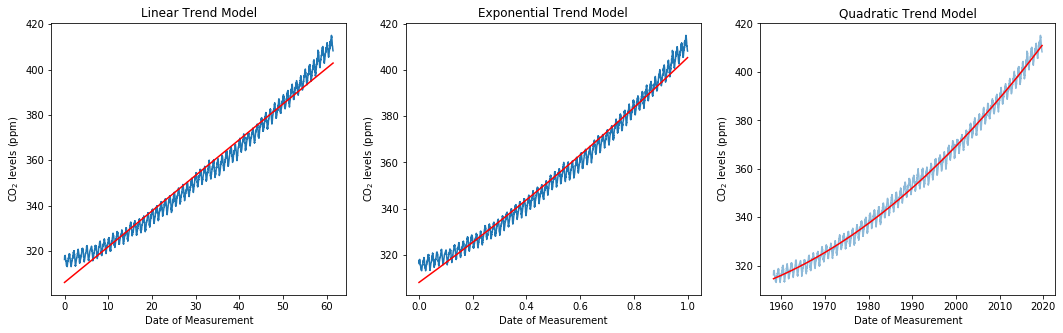

In [55]:
# plots showing the trend curves for the 
# linear, exponential & quadratic models

linear_samples = linear_results.extract()
exp_samples = exp_results.extract()
quadratic_samples = quadratic_results.extract()

linear_approx = linear_samples['c0'].mean() + linear_samples['c1'].mean()*data.Years.values

exp_approx = (exp_samples['c0'].mean()*np.exp(exp_samples['c1'].mean()*data.Years.values/np.max(data.Years.values)))

quadratic_approx = (quadratic_samples['c0'].mean() +
                    quadratic_samples['c1'].mean()*data.Years.values +
                    quadratic_samples['c2'].mean()*data.Years.values**2)


figure_3 = plt.figure(figsize=(18,5))
plt.subplot(1, 3, 1)
plt.plot(data.Years.values, data.CO2_concentration)
plt.plot(data.Years.values, linear_approx, color='red')
plt.title("Linear Trend Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 2)
plt.plot(data.Years.values / np.max(data.Years.values), data.CO2_concentration)
plt.plot(data.Years.values / np.max(data.Years.values), exp_approx, color='red')
plt.title("Exponential Trend Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 3)
plt.plot(data.Date, data.CO2_concentration, alpha=0.5)
plt.plot(data.Date, quadratic_approx, color="red")
plt.title("Quadratic Trend Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()
# fig3.savefig("Figure3.png")

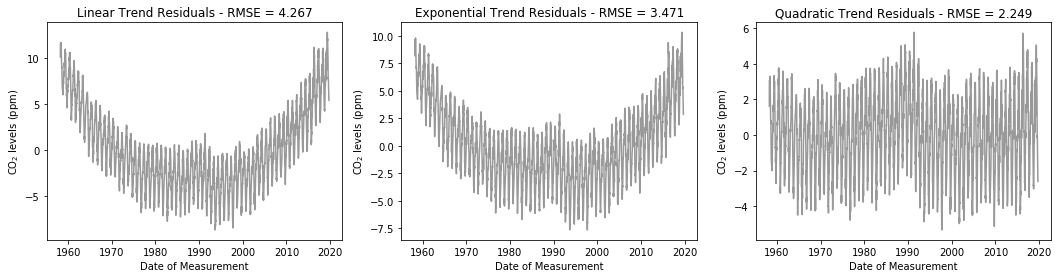

In [59]:
# calculating the RMSE for the linear, exponential and quadratic trend models
# we'll use the one with the least RMSE 
linear_residuals = data.CO2_concentration - linear_approx
quadratic_residuals = data.CO2_concentration - quadratic_approx
exponential_residuals = data.CO2_concentration - exp_approx

linear_RMSE = np.sqrt(np.mean(linear_residuals**2))
quadratic_RMSE = np.sqrt(np.mean(quadratic_residuals**2))
exponential_RMSE = np.sqrt(np.mean(exponential_residuals**2))

figure_4 = plt.figure(figsize=(18,4))
plt.subplot(1, 3, 1)
plt.plot(data.Date, linear_residuals, alpha = 0.8, color="grey")
plt.title("Linear Trend Residuals - RMSE = {:.3f}".format(linear_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 2)
plt.plot(data.Date, exponential_residuals, alpha = 0.8, color="grey")
plt.title("Exponential Trend Residuals - RMSE = {:.3f}".format(exponential_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 3)
plt.plot(data.Date, quadratic_residuals, alpha = 0.8, color="grey")
plt.title("Quadratic Trend Residuals - RMSE = {:.3f}".format(quadratic_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()

Recall that figure 1 has repeated small dips in the curve. Next, we're going to try to better understand what's going on. But first, we need to remove the influuence of the upward trend by taking the first difference of values. This will give us the month-to-month changes in carbon dioxide

In [60]:
data['Differenced_Seqence'] = data.CO2_concentration - quadratic_approx

In [62]:
data.head()

,Date,CO2_concentration,Days_Passed,Years,Differenced_Seqence
0,1958-03-29,316.19,0,0.000000,1.611577
1,1958-04-05,317.31,7,0.019165,2.716873
2,1958-04-12,317.69,14,0.038330,3.082159
3,1958-04-19,317.58,21,0.057495,2.957436
4,1958-04-26,316.48,28,0.076660,1.842703


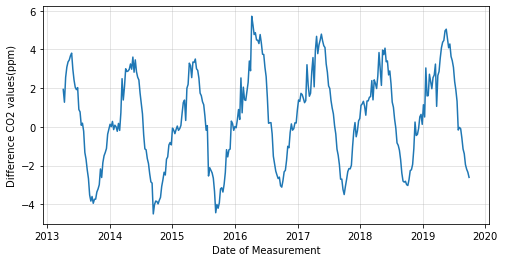

In [64]:
figure_5 = plt.figure(figsize=(8,4))
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["Differenced_Seqence"]])
plt.grid(alpha=0.4)
plt.xlabel("Date of Measurement")
plt.ylabel("Difference CO2 values(ppm)")
plt.show()

In [97]:
def aperiodic_sine(x, c0, c1, c2, c3, c4):
    '''
    '''
    return ((-(1+np.exp(-c0* c3*x +c4)) *
            np.arctan(
            np.sin(c3*x +c4) / (1+np.exp(-c1)-np.cos(c3*x+4)) + c2 )))

In [105]:
stan_seasonality_data = {
    "N" : len(data),
    "co2" : data.Differenced_Seqence.values,
    "time" : data.Years.values,
    "period" : 2*np.pi
}

stan_seasonality_data_ = {
    "N" : len(data),
    "time" : data['Days_Passed'],
    'co2': data['CO2_concentration']
}

In [108]:
sine_approx = """
data {
    int<lower=0> N;             // number of data
    real<lower=0> time[N];     // days since start of measurement
    real co2[N];                // measured CO2 in ppm
    real<lower=0> period;
}

parameters {
    real<lower=0> c0;                
    real<lower=0, upper=1> c1_helper;
    real<lower=0, upper=1> c1_helper2;
    real<lower=0> noise;
}

transformed parameters {
    real c1 = atan2(c1_helper, c1_helper2);
}

model {
 
    // Priors
    c0 ~ gamma(4, 2);
    noise ~ inv_gamma(3, 2);

    for (i in 1:N) {
        co2[i] ~ normal(c0 * sin(period*time[N] + c1), noise); 
    }
}

"""

cosine_approx = """
data {
    int<lower=0> N;             // number of data
    real<lower=0> time[N];     // days since start of measurement
    real co2[N];                // measured CO2 in ppm
    real<lower=0> period;
}

parameters {
    real<lower=0> c0;                
    real<lower=0, upper=1> c1_helper;
    real<lower=0, upper=1> c1_helper2;
    real<lower=0> noise;
}

transformed parameters {
    real<lower=0> c1 = atan2(c1_helper, c1_helper2);
}

model {
 
    // Priors
    c1_helper ~ beta(1,1);
    c1_helper2 ~ beta(1,1);
    c0 ~ gamma(4, 2);
    noise ~ inv_gamma(3, 2);

    for (i in 1:N) {
        co2[i] ~ normal(c0 * cos(period*time[N] + c1), noise); 
    }
}

"""

double_sine_approx = """
data {
    int<lower=0> N;             // number of data
    real<lower=0> time[N];       // days since start of measurement
    real co2[N];      // measured ppm
    real<lower=0> period;
}

parameters {
    real<lower=0> c0;                
    real<upper=0> c1;
    unit_vector[2] phase_helper1;
    real<lower=0> noise;
}

transformed parameters {
    real phase1 = atan2(phase_helper1[1],phase_helper1[2]);
}

model {
 
    // Priors
    c0 ~ normal(0, 4);
    c1 ~ normal(0, 4);
    noise ~ inv_gamma(3, 2);

    for (i in 1:N) {
        co2[i] ~ normal(c0*sin(period*time[i] + phase1) + c1*sin(period*2*time[i] + phase1), noise); 
    }
}

"""

aperiodic_sine_wave_approx = """
data {
    int<lower=0> N;             // number of data
    real<lower=0> time[N];     // days since start of measurement
    real co2[N];                // measured CO2 in ppm
}

parameters {                    //labelled by how they affect the function
    real<lower=0> c0_exp; 
    real<lower=0> c1_exp;
    real<lower=0> c2_updown;
    real<lower=0> c3_scale;
    real<lower=0> c4_leftright;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0_exp ~ gamma(1, 1);
    c1_exp ~ gamma(1, 1);
    c2_updown ~ gamma(1, 1);
    c3_scale ~ gamma(6, 2);
    c4_leftright ~ gamma(1, 1);

    noise ~ inv_gamma(3, 2);

    for (i in 1:N) {
        co2[i] ~ normal( (-(1 + exp(-c0_exp * c3_scale * time[N] + c4_leftright) *
                         atan( 
                         sin(c3_scale * time[N] + c4_leftright) /
                         (1 + exp(-c1_exp) - cos(c3_scale * time[N] + c4_leftright)) ))) + c2_updown, noise); 
    }
}

"""

tilted_sine_quadratic_approx = """
data {
    int<lower=0> N;  // number of collected data points
    real<lower=0> co2[N];  // data for levels         
    real<lower=0> time[N]; // data for days   
}

parameters {
    real<lower=0> c_0;  // intercept
    real<lower=0> c_1;  // 1st degree polynomial 
    real<lower=0> c_2;  // 2nd degree polynomial 
    real<lower=0> noise; 
    
    real<lower=0> amplitude; 
    real<lower=0,upper=pi()> phi; // phi
}


model {
    // priors 
    c_0 ~ normal(300, 30);
    c_1 ~ normal(0,10);
    c_2 ~ normal(0,10);
    noise ~ normal(0, 8);
    
    amplitude ~ normal(0,1);
    phi ~ cauchy(0, 10);
       
    
    // model
        for (i in 1:N) {   
            co2[i] ~ normal(c_0 + c_1*time[i] + c_2*time[i]^2 +     
            amplitude/phi*atan((phi*sin((2*pi()*time[i])/365.25)+phi)/
                        (1-phi*cos((2*pi()*time[i])/365.25)+phi)), noise);
    }
}
"""


In [109]:
sine_model = pystan.StanModel(model_code=sine_approx)
cosine_model = pystan.StanModel(model_code=cosine_approx)
double_sine_model = pystan.StanModel(model_code=double_sine_approx)
aperiodic_sine_wave_model = pystan.StanModel(model_code=aperiodic_sine_wave_approx)
tilted_sine_quadratic_model = pystan.StanModel(model_code=tilted_sine_quadratic_approx)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_02062766c5c44b91ff89b0527834e333 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6eeb0f2bad0c9cff4a7c186332318db2 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2eb2a051271c5521f1804c5b61e61206 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bfd9d2d016302849a3e79a17a5725aae NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_15c4b6816408b0223be0148ee7b10f75 NOW.


In [79]:
sine_results = sine_model.sampling(data=stan_seasonality_data, iter=1000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 12, 'adapt_delta' : 0.9999},
                              refresh = 10)
print(sine_results)

Inference for Stan model: anon_model_02062766c5c44b91ff89b0527834e333.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0           1.49    0.03   0.85   0.32   0.87   1.36   1.96   3.53   1135   1.01
c1_helper    0.02  9.7e-4   0.03 3.2e-4 4.3e-3   0.01   0.03   0.09    924    1.0
c1_helper2   0.67  6.4e-3   0.23   0.14   0.51   0.71   0.86   0.98   1279    1.0
noise        2.25  8.3e-4   0.03   2.19   2.23   2.25   2.27    2.3   1115    1.0
c1           0.03  1.2e-3   0.04 6.0e-4 7.6e-3   0.02   0.04   0.13   1009    1.0
lp__        -4126    0.06   1.59  -4130  -4126  -4125  -4124  -4124    636   1.01

Samples were drawn using NUTS at Fri Dec 20 00:53:24 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [81]:
cosine_results = cosine_model.sampling(data=stan_seasonality_data, iter=1000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 12, 'adapt_delta' : 0.9999},
                              refresh = 10)
print(cosine_results)

Inference for Stan model: anon_model_6eeb0f2bad0c9cff4a7c186332318db2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0           1.55    0.02   0.89   0.31   0.91   1.38   2.03   3.66   1536    1.0
c1_helper    0.66  7.5e-3   0.25   0.12    0.5   0.72   0.87   0.99   1075    1.0
c1_helper2   0.02  1.2e-3   0.03 5.4e-4 5.3e-3   0.01   0.03    0.1    694    1.0
noise        2.25  8.5e-4   0.03    2.2   2.23   2.25   2.27    2.3   1049    1.0
c1           1.54  1.4e-3   0.04   1.45   1.53   1.55   1.56   1.57    754    1.0
lp__        -4125    0.06   1.56  -4130  -4126  -4125  -4124  -4124    641    1.0

Samples were drawn using NUTS at Fri Dec 20 00:56:52 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [82]:
double_sine_results = double_sine_model.sampling(data=stan_seasonality_data, iter=1000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 12, 'adapt_delta' : 0.9999},
                              refresh = 10)
print(double_sine_results)

Inference for Stan model: anon_model_2eb2a051271c5521f1804c5b61e61206.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0                 2.86  6.1e-4   0.02   2.81   2.84   2.86   2.88    2.9   1421    1.0
c1                -0.52  7.3e-4   0.02  -0.57  -0.54  -0.52   -0.5  -0.47   1079    1.0
phase_helper1[1]   0.93  6.7e-5 3.0e-3   0.92   0.93   0.93   0.93   0.94   1946    1.0
phase_helper1[2]   0.37  1.7e-4 7.5e-3   0.35   0.36   0.37   0.37   0.38   1952    1.0
noise              0.92  3.3e-4   0.01   0.89   0.91   0.92   0.92   0.94   1205    1.0
phase1             1.19  1.8e-4 8.1e-3   1.18   1.19   1.19    1.2   1.21   1951    1.0
lp__              -1302    0.07   1.62  -1305  -1302  -1301  -1300  -1299    593   1.01

Samples were drawn using NUTS at Fri Dec 20 01:10:29 2019.
For each parameter, n_eff is a crude measure of e

In [102]:
aperiodic_sine_wave_results = aperiodic_sine_wave_model.sampling(data=stan_seasonality_data, iter=1000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 12, 'adapt_delta' : 0.9999},
                              refresh = 10)
print(aperiodic_sine_wave_results)

Inference for Stan model: anon_model_bfd9d2d016302849a3e79a17a5725aae.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0_exp         1.02    0.02   0.96   0.05   0.32   0.75   1.38   3.68   1560    1.0
c1_exp         1.02    0.02   1.02   0.03   0.28    0.7   1.46    3.8   2146    1.0
c2_updown       1.0  9.9e-4   0.04   0.92   0.97    1.0   1.02   1.07   1572    1.0
c3_scale       3.01    0.03    1.2   1.08   2.14   2.87   3.75   5.75   1483    1.0
c4_leftright    1.0    0.02    1.0   0.02   0.29   0.68    1.4   3.68   1985    1.0
noise          2.25  7.4e-4   0.03   2.19   2.23   2.25   2.27   2.31   1570    1.0
lp__          -4122    0.07    1.8  -4127  -4123  -4122  -4121  -4120    724    1.0

Samples were drawn using NUTS at Fri Dec 20 03:31:36 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat i

In [110]:
tilted_sine_quadratic_results = tilted_sine_quadratic_model.sampling(data=stan_seasonality_data_)
print(tilted_sine_quadratic_results)

Inference for Stan model: anon_model_15c4b6816408b0223be0148ee7b10f75.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0       312.38  2.1e-3    0.1 312.19 312.32 312.38 312.45 312.58   2115    1.0
c_1       2.1e-3  4.5e-7 1.8e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3   1632    1.0
c_2       9.7e-8 1.9e-117.8e-10 9.5e-8 9.6e-8 9.7e-8 9.7e-8 9.8e-8   1690    1.0
noise       1.62  4.5e-4   0.02   1.58   1.61   1.62   1.64   1.66   2282    1.0
amplitude   9.49    0.01   0.48   8.56   9.15   9.48   9.82  10.43   1218    1.0
phi         2.77  4.9e-3   0.16   2.45   2.65   2.76   2.88   3.09   1134    1.0
lp__       -3148    0.07   1.92  -3153  -3149  -3148  -3147  -3146    863    1.0

Samples were drawn using NUTS at Fri Dec 20 09:12:18 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale 

In [111]:
sine_samples = sine_results.extract()
cos_samples = cosine_results.extract()
double_sine_samples = double_sine_results.extract()
aperiodic_sine_wave_samples = aperiodic_sine_wave_results.extract()
tilted_sine_quadratic_samples = tilted_sine_quadratic_results.extract()

In [112]:
sine_approx = sine_samples['c0'].mean() * np.sin(2*np.pi*data.Years.values + sine_samples['c1'].mean())

cos_approx = cos_samples['c0'].mean() * np.cos(2*np.pi*data.Years.values + cos_samples['c1'].mean())

double_sine_approx = double_sine_samples['c0'].mean()*np.sin(
                                 2*np.pi*data.Years.values + double_sine_samples['phase1'].mean()) + \
                              double_sine_samples['c1'].mean()*np.sin(
                                 4*np.pi*data.Years.values + double_sine_samples['phase1'].mean())

aperiodic_sine_wave_approx = aperiodic_sine(data.Years.values, 
                                            aperiodic_sine_wave_samples['c0_exp'].mean(),
                                            aperiodic_sine_wave_samples['c1_exp'].mean(),
                                            aperiodic_sine_wave_samples['c2_updown'].mean(),
                                            aperiodic_sine_wave_samples['c3_scale'].mean(),
                                            aperiodic_sine_wave_samples['c4_leftright'].mean())

In [ ]:
figure_6 = plt.figure(figsize=(18,5))
plt.subplot(1, 3, 1)
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["Differenced_Seqence"]], alpha=0.5)
plt.plot(data.loc[2800:, ["Date"]], sine_approx[2800:], color="red")
plt.title("Sine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 2)
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["Differenced_Seqence"]], alpha=0.5)
plt.plot(data.loc[2800:, ["Date"]], cosine_approx[2800:], color="red")
plt.title("Cosine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 3)
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["Differenced_Seqence"]], alpha=0.5)
plt.plot(data.loc[2800:, ["Date"]], double_sine_approx[2800:], color="red")
plt.title("Double Sine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 4)
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["Differenced_Seqence"]], alpha=0.5)
plt.plot(data.loc[2800:, ["Date"]], aperiodic_sine_wave_approx[2800:], color="red")
plt.title("Double Sine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 5)
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["Differenced_Seqence"]], alpha=0.5)
plt.plot(data.loc[2800:, ["Date"]], double_negative_sine_approx[2800:], color="red")
plt.title("Double Sine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()